# Explore the main sweep8 dataset

In [100]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import re

In [74]:
# Shorter version of the essays dataset for qual software
essays_sent = pd.read_csv('essays_sentiment.csv')
essays[:100][['ID', 'Preprocessed Text']].to_csv('essays100.csv', index=False)
essays_sent.head()

,ID,Essay Text,Preprocessed Text,Essay Length,Sentiment,Score
0,N28280Y,"I am happily married, we are grand-parents. Ou...","['happily', 'married', 'grandparent', 'two', '...",247,POSITIVE,0.998764
1,N13960Q,"I am retired, not living in London, probably i...","['retired', 'living', 'london', 'probably', 'n...",460,POSITIVE,0.953925
2,N23786Z,I imagine I'll still be teaching french at Pri...,"['imagine', 'ill', 'still', 'teaching', 'frenc...",441,POSITIVE,0.763161
3,N17606R,I am retired from work. I enjoy leisurely time...,"['retired', 'work', 'enjoy', 'leisurely', 'tim...",209,POSITIVE,0.998788
4,N19466F,"Retired and moved further away from London, Su...","['retired', 'moved', 'away', 'london', 'sussex...",238,POSITIVE,0.997543


In [29]:
# Read and explore the main sweep 8 dataset
sweep8 = pd.read_stata('ncds_2008_followup.dta')
sweep8.head()

,NCDSID,N8OUTCOM,N8INTMON,N8INTYR,N8GOR,N8CNTRY,N8REGION,ND8MS,ND8COHAB,ND8SEX,...,ND8RLME,ND8ENFA,ND8EMWB,ND8SOCF,ND8PAIN,ND8GENH,ND8CSP12,ND8CSP14,N8PARENT,N8ANOINT
0,N10001N,Productive interview,11.0,2008.0,South West,England,South West,Divorced,No,Female,...,100.0,95.0,100.0,53.0,100.0,100.0,24.0,29.0,Yes,265.0
1,N10002P,Productive interview,11.0,2008.0,South East,England,South East,Married,Item not applicable,Male,...,100.0,70.0,92.0,53.0,90.0,85.0,32.0,37.0,Item not applicable,67.0
2,N10007U,Productive interview,10.0,2008.0,South West,England,South West,Married,Item not applicable,Female,...,100.0,95.0,96.0,53.0,90.0,90.0,34.0,40.0,Item not applicable,49.0
3,N10008V,Productive interview,10.0,2008.0,North West,England,North West,Married,Item not applicable,Male,...,66.67,70.0,68.0,53.0,70.0,65.0,26.0,30.0,Yes,140.0
4,N10009W,Productive interview,11.0,2008.0,London,England,South East,Single & never married,No,Male,...,100.0,80.0,92.0,53.0,100.0,85.0,30.0,36.0,Yes,275.0


### Clean the sweep8 dataset and keep what is relevant

In the cell below, we create two datasets which capture people's physical and emotional well-being, leisure time and personality. In the larger dataset, we keep the original variables related to these areas and in the smaller one, we only include summary measures.

In [189]:
# Filter 2 work variables
work = sweep8.filter(['NCDSID','N8SCQ16C','N8SCQ20C'])

# Recode responses: Any job better than no job
any_job = {'Strongly agree':1, 'Agree':2, 'Neither agree or disagree':3,
          'Disagree':4, 'Strongly disagree':5}

# Recode the selected columns in the DataFrame using .loc[row_indexer, col_indexer]
work.loc[:, 'N8SCQ16C'] = work.loc[:, 'N8SCQ16C'].replace(any_job)

# Recode responses: Having fullfilling job important
fullfilling = {'Very important':1, '9.0':2, '8.0':3, '7.0':4, '6.0':5,
              '5.0':6, '4.0':7, '3.0':8, '2.0':9, 'Not important at all':10}

# Recode the selected columns in the DataFrame using .loc[row_indexer, col_indexer]
work.loc[:, 'N8SCQ20C'] = work.loc[:, 'N8SCQ20C'].replace(fullfilling)

work_cols = ['N8SCQ16C','N8SCQ20C']

# Convert 'Value' column to float, replace invalid values with NaN
for column in work[work_cols]:
    work[column] = pd.to_numeric(work[column], errors='coerce')

work.info()
work.to_csv('work.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9790 entries, 0 to 9789
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   NCDSID    9790 non-null   object 
 1   N8SCQ16C  8731 non-null   float64
 2   N8SCQ20C  8743 non-null   float64
dtypes: float64(2), object(1)
memory usage: 229.6+ KB


In [184]:
# Keep variables related to free time and personality
leisure_pers = sweep8.filter(regex='^N8SC|NCDSID')
leisure_pers.head()
leisure_pers.columns

# Use regular expressions to filter relevant variables
leisure = leisure_pers.filter(regex='^N8SCQ1[A-Z\s]|NCDSID')
personality = leisure_pers.filter(regex='^N8SCQ2|NCDSID')
mental_health = leisure_pers.filter(regex='^N8SCQ[3,10,19]|NCDSID')
health = leisure_pers.filter(regex='^N8SCQ[4-9,11-15]|NCDSID')
health.head()

wellbeing_large = pd.merge(mental_health, health, on='NCDSID',how='inner')
leisure_persl = pd.merge(personality, leisure, on='NCDSID',how='inner')
wellbeingL = pd.merge(wellbeing_large, leisure_persl, on='NCDSID',how='inner')

# Filter summary variables for personality, mental and physical well-being
wellbeing_vars = ['NCDSID','ND8EXT','ND8AGR','ND8CON','ND8EMO','ND8INT','ND8WEMWB','ND8PHHE','ND8RLME','ND8ENFA','ND8EMWB','ND8PAIN','ND8SOCF','ND8GENH','ND8CSP12']
wellbeing = sweep8.filter(wellbeing_vars)
wellbeing = pd.merge(wellbeing, work, on='NCDSID', how='inner')
wellbeing.head()

,NCDSID,ND8EXT,ND8AGR,ND8CON,ND8EMO,ND8INT,ND8WEMWB,ND8PHHE,ND8RLME,ND8ENFA,ND8EMWB,ND8PAIN,ND8SOCF,ND8GENH,ND8CSP12,N8SCQ16C,N8SCQ20C
0,N10001N,30.0,44.0,44.0,31.0,38.0,61.0,100.0,100.0,95.0,100.0,100.0,53.0,100.0,24.0,1.0,9.0
1,N10002P,37.0,27.0,37.0,32.0,34.0,55.0,100.0,100.0,70.0,92.0,90.0,53.0,85.0,32.0,2.0,7.0
2,N10007U,34.0,41.0,33.0,41.0,37.0,65.0,100.0,100.0,95.0,96.0,90.0,53.0,90.0,34.0,2.0,8.0
3,N10008V,21.0,40.0,35.0,24.0,30.0,63.0,100.0,66.67,70.0,68.0,70.0,53.0,65.0,26.0,1.0,1.0
4,N10009W,32.0,44.0,37.0,43.0,36.0,55.0,100.0,100.0,80.0,92.0,100.0,53.0,85.0,30.0,2.0,8.0


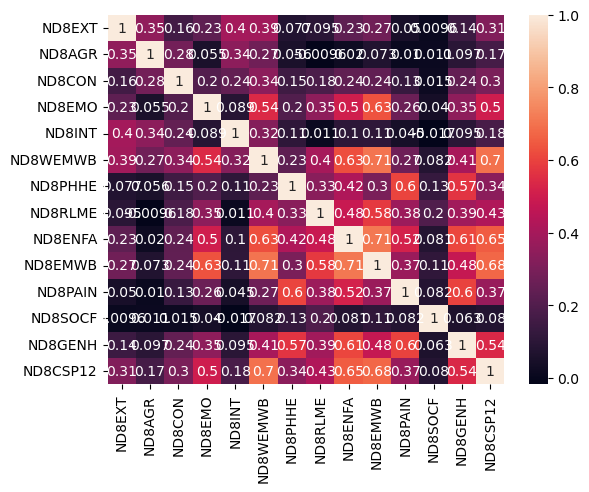

In [77]:
# Explore the wellbeing datasets and look for patterns between variables
wellbeingNoID = wellbeing.drop('NCDSID', axis=1)
wellbeing_varsNoID = ['ND8EXT','ND8AGR','ND8CON','ND8EMO','ND8INT','ND8WEMWB','ND8PHHE','ND8RLME','ND8ENFA','ND8EMWB','ND8PAIN','ND8SOCF','ND8GENH','ND8CSP12']

# Convert 'Value' column to float, replace invalid values with NaN
for column in wellbeing_varsNoID:
    wellbeingNoID[column] = pd.to_numeric(wellbeingNoID[column], errors='coerce')

wellbeing_corr = wellbeingNoID.corr()
#print(wellbeing_corr)

# Visualize correlations between variables
sn.heatmap(wellbeing_corr, annot=True)
plt.show()

#### Leisure dataset

Here we conduct some exploratory analysis of our leisure data. First, we recode them and then, look at some correlations and patterns. 

In [135]:
# Check for duplicate column names
duplicate_columns = leisure.columns.duplicated()
print(duplicate_columns)

# Get the list of duplicate column names
duplicate_column_names = leisure.columns[duplicate_columns]
print(duplicate_column_names)

# Rename the duplicate columns to make them unique
for column in duplicate_column_names:
    new_column_name = column + '_duplicate'  # Modify the column name as per your preference
    leisure.rename(columns={column: new_column_name}, inplace=True)

[False False False False False False False False False False False False
 False]
Index([], dtype='object')


In [136]:
leisure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9790 entries, 0 to 9789
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   NCDSID   9790 non-null   object  
 1   N8SCQ1A  9789 non-null   category
 2   N8SCQ1B  9789 non-null   category
 3   N8SCQ1C  9789 non-null   category
 4   N8SCQ1D  9789 non-null   category
 5   N8SCQ1E  9789 non-null   category
 6   N8SCQ1F  9789 non-null   category
 7   N8SCQ1G  9789 non-null   category
 8   N8SCQ1H  9789 non-null   category
 9   N8SCQ1I  9789 non-null   category
 10  N8SCQ1J  9789 non-null   category
 11  N8SCQ1K  9789 non-null   category
 12  N8SCQ1L  9789 non-null   category
dtypes: category(12), object(1)
memory usage: 195.6+ KB


In [173]:
# Clean the leisure dataset and recode variables
leisure.head()
leisure_vars = ['N8SCQ1A', 'N8SCQ1B', 'N8SCQ1C', 'N8SCQ1D', 'N8SCQ1E',
       'N8SCQ1F', 'N8SCQ1G', 'N8SCQ1H', 'N8SCQ1I', 'N8SCQ1J', 'N8SCQ1K',
       'N8SCQ1L']

# Define the recoding mapping
recoding = {'At least once a week': 5, 'At least once a month': 4, 
            'Several times a year': 3, 'Once a year or less': 2,
            'Never/almost never':1}

# Recode the selected columns in the DataFrame using .loc[row_indexer, col_indexer]
leisure.loc[:, leisure_vars] = leisure.loc[:, leisure_vars].replace(recoding)
leisure.columns

Index(['NCDSID', 'N8SCQ1A', 'N8SCQ1B', 'N8SCQ1C', 'N8SCQ1D', 'N8SCQ1E',
       'N8SCQ1F', 'N8SCQ1G', 'N8SCQ1H', 'N8SCQ1I', 'N8SCQ1J', 'N8SCQ1K',
       'N8SCQ1L', 'LeisureIndex'],
      dtype='object')

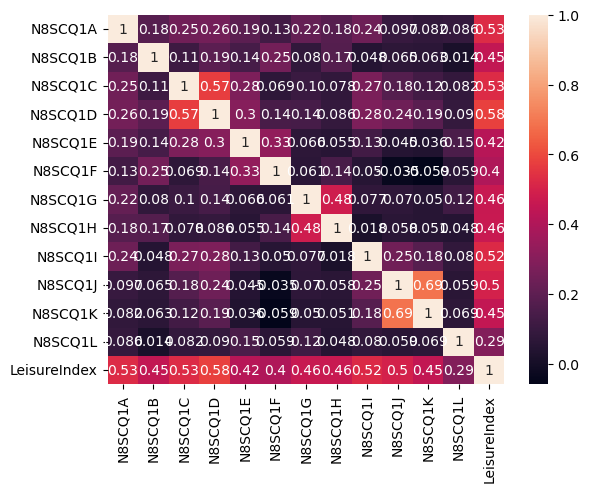

In [160]:
# Explore the wellbeing datasets and look for patterns between variables
leisureNoID = leisure.drop('NCDSID', axis=1)

# Convert 'Value' column to float, replace invalid values with NaN
for column in leisure_vars:
    leisureNoID[column] = pd.to_numeric(leisureNoID[column], errors='coerce')
    
# Correlation matrix of leisure activities
leisure_corr = leisureNoID.corr()
#print(wellbeing_corr)

# Visualize correlations between variables
sn.heatmap(leisure_corr, annot=True)
plt.show()

In [186]:
# Leisure activity index: 

# Convert the columns to numeric type
leisure[leisure_vars] = leisure[leisure_vars].apply(pd.to_numeric, errors='coerce')

# proxy of how much time a person spends on leisure relatively to other people
leisure['LeisureIndex'] = leisure[leisure_vars].mean(axis=1)
leisure.head()

/var/folders/_v/0ysnzh811hj_hnrpjkv8j6fw0000gn/T/ipykernel_60132/2011599059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leisure[leisure_vars] = leisure[leisure_vars].apply(pd.to_numeric, errors='coerce')
/var/folders/_v/0ysnzh811hj_hnrpjkv8j6fw0000gn/T/ipykernel_60132/2011599059.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leisure['LeisureIndex'] = leisure[leisure_vars].mean(axis=1)


,NCDSID,N8SCQ1A,N8SCQ1B,N8SCQ1C,N8SCQ1D,N8SCQ1E,N8SCQ1F,N8SCQ1G,N8SCQ1H,N8SCQ1I,N8SCQ1J,N8SCQ1K,N8SCQ1L,LeisureIndex
0,N10001N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N10002P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N10007U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N10008V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N10009W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
# Make sure all relevant wellbeing variables are numeric
wellbeing_vars = ['ND8EXT','ND8AGR','ND8CON','ND8EMO','ND8INT','ND8WEMWB','ND8PHHE',
                  'ND8RLME','ND8ENFA','ND8EMWB','ND8PAIN','ND8SOCF','ND8GENH','ND8CSP12']

# Convert 'Value' column to float, replace invalid values with NaN
for column in wellbeing_vars:
    wellbeing[column] = pd.to_numeric(wellbeing[column], errors='coerce')

# merge leisure and wellbeing datasets
LeisureWellbeing = pd.merge(wellbeing, leisure, on='NCDSID',how='inner',)
LWNoID = LeisureWellbeing.drop('NCDSID',axis=1)

# Correlation matrix of leisure activities
# Exclude non-numeric columns from the correlation calculation
numeric_cols = LWNoID.select_dtypes(include=np.number).columns
LW_corr = LWNoID[numeric_cols].corr()

# Only wellbeing cols and leisure index
WLI_cols = ['ND8EXT','ND8AGR','ND8CON','ND8EMO','ND8INT','ND8WEMWB','ND8PHHE','ND8RLME',
            'ND8ENFA','ND8EMWB','ND8PAIN','ND8SOCF','ND8GENH','ND8CSP12','LeisureIndex']
WLI_corr = LWNoID[WLI_cols].corr()

In [188]:
LeisureWellbeing.head()
LeisureWellbeing.to_csv('LeisureWellbeing.csv', index=False)

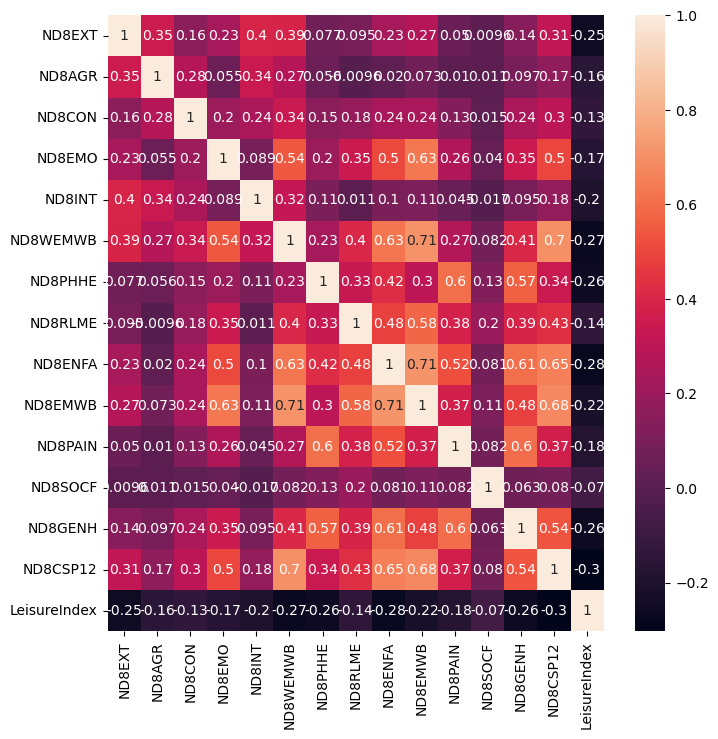

In [176]:
# Visualize correlations between variables

# Set the figure size
fig, ax = plt.subplots(figsize=(8, 8))

# Create the heatmap using seaborn
sn.heatmap(WLI_corr, ax=ax, annot=True)
plt.show()